# User Total Active Time as Metric

In [629]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [630]:
# reading the data sets
t1_user_active_min     = pd.read_csv("t1_user_active_min.csv")
t2_user_variant        = pd.read_csv("t2_user_variant.csv")
t3_user_active_min_pre = pd.read_csv("t3_user_active_min_pre.csv")
t4_user_attributes     = pd.read_csv("t4_user_attributes.csv")

# Use table 1 and 2

In [631]:
t1_user_active_min.head()

,uid,dt,active_mins
0,0,2019-02-22,5.0
1,0,2019-03-11,5.0
2,0,2019-03-18,3.0
3,0,2019-03-22,4.0
4,0,2019-04-03,9.0


In [632]:
t2_user_variant.head()

,uid,variant_number,dt,signup_date
0,0,0,2019-02-06,2018-09-24
1,1,0,2019-02-06,2016-11-07
2,2,0,2019-02-06,2018-09-17
3,3,0,2019-02-06,2018-03-04
4,4,0,2019-02-06,2017-03-09


In [633]:
# Drop data with active_mins more than (24 hrs * 60 mins) on a single date.
t1_user_active_min = t1_user_active_min[t1_user_active_min.active_mins <= 24*60]

In [634]:
# Total minutes per user
t1_user_active_min_total = t1_user_active_min.groupby(by=['uid'], as_index=False).sum()

In [635]:
# merge t1 and t2 by uid
t12 = pd.merge(t2_user_variant, t1_user_active_min_total, on='uid')

In [636]:
t12.head()

,uid,variant_number,dt,signup_date,active_mins
0,0,0,2019-02-06,2018-09-24,43.0
1,1,0,2019-02-06,2016-11-07,15205.0
2,2,0,2019-02-06,2018-09-17,17.0
3,3,0,2019-02-06,2018-03-04,77.0
4,4,0,2019-02-06,2017-03-09,39.0


In [637]:
t12.variant_number.value_counts()

0    37425
1     9208
Name: variant_number, dtype: int64

# Compute confidence interval on difference of means.

In [638]:
stats12 = t12.groupby(['variant_number'])['active_mins'].agg(['mean', 'count', 'std','var'])
stats12

,mean,count,std,var
variant_number,,,,
0,458.221162,37425,1653.447132,2.733887e+06
1,458.402476,9208,1680.571091,2.824319e+06


In [639]:
sigma_diff = np.sqrt(stats12.loc[0]['var'] / stats12.loc[0]['count'] + 
                     stats12.loc[1]['var'] / stats12.loc[1]['count'])
upper = (stats12.loc[1]['mean'] - stats12.loc[0]['mean']) + (1.96 * sigma_diff)
lower = (stats12.loc[1]['mean'] - stats12.loc[0]['mean']) - (1.96 * sigma_diff)
print([lower, upper])

[-38.01476992103114, 38.37739748719736]


Perform a t-test:

In [640]:
stats.ttest_ind(t12.active_mins[t12.variant_number==1], t12.active_mins[t12.variant_number==0], equal_var =False)

Ttest_indResult(statistic=0.009303964709989936, pvalue=0.9925767506273644)

The high p-value suggests INSUFFICIENT evidence for the new UI design to make a positive impact on total active time per user.

# Add Table 3

In [641]:
t3_user_active_min_pre.head()

,uid,dt,active_mins
0,0,2018-09-24,3.0
1,0,2018-11-08,4.0
2,0,2018-11-24,3.0
3,0,2018-11-28,6.0
4,0,2018-12-02,6.0


In [642]:
# Drop data with active_mins more than (24 hrs * 60 mins) on a single date.
t3_user_active_min_pre = t3_user_active_min_pre[t3_user_active_min_pre.active_mins <= 24*60]

In [643]:
# Total minutes per user
t3_user_active_min_pre_total = t3_user_active_min_pre.groupby(by=['uid'], as_index=False).sum()

In [644]:
t123 = pd.merge(t12, t3_user_active_min_pre_total, on='uid', suffixes=('_post', '_pre'))

In [645]:
t123.head()

,uid,variant_number,dt,signup_date,active_mins_post,active_mins_pre
0,0,0,2019-02-06,2018-09-24,43.0,70.0
1,1,0,2019-02-06,2016-11-07,15205.0,19158.0
2,2,0,2019-02-06,2018-09-17,17.0,37.0
3,3,0,2019-02-06,2018-03-04,77.0,108.0
4,4,0,2019-02-06,2017-03-09,39.0,66.0


In [646]:
t123['active_mins_diff'] = t123['active_mins_post'] - t123['active_mins_pre']

In [648]:
stats123 = t123.groupby(['variant_number'])['active_mins_post', 'active_mins_pre', 'active_mins_diff'].agg(['mean', 'count', 'std','var'])
stats123

active_mins_post                                    \
                           mean  count          std           var   
variant_number                                                      
0                    459.544824  37313  1655.747990  2.741501e+06   
1                    460.465139   9165  1684.238222  2.836658e+06   

               active_mins_pre                                    \
                          mean  count          std           var   
variant_number                                                     
0                    506.84027  37313  1874.763969  3.514740e+06   
1                    295.81102   9165  1118.898491  1.251934e+06   

               active_mins_diff                                    
                           mean  count          std           var  
variant_number                                                     
0                    -47.295447  37313   968.271500  9.375497e+05  
1                    164.654119   9165  1020.378387  1.041172e+06

# Difference in difference

For each user, first obtain difference in post-test total time and pre-test total time: $\Delta x_1 \equiv x_{1,post} - x_{1,pre}$ and $\Delta x_2 \equiv x_{0,post} - x_{0,pre}$

Then obtain the difference in mean: $\overline{\Delta x_1} - \overline{\Delta x_2}$ <br>

Standard Error: $\sqrt{\frac{s_{\Delta x_1}^2}{n_1} + \frac{s_{\Delta x_2}^2}{n_1}}$

In [649]:
mean_did = stats123.loc[1,'active_mins_diff']['mean'] - stats123.loc[0,'active_mins_diff']['mean']

sigma_did = np.sqrt(stats123.loc[1,'active_mins_diff']['var'] / stats123.loc[1,'active_mins_diff']['count'] + 
                    stats123.loc[0,'active_mins_diff']['var'] / stats123.loc[0,'active_mins_diff']['count'])

upper = mean_did + (1.96 * sigma_did)
lower = mean_did - (1.96 * sigma_did)
print([lower, upper])

[188.86398661059266, 235.03514450519842]


Perform a t-test:

In [650]:
stats.ttest_ind(t123.active_mins_diff[t123.variant_number==1], t123.active_mins_diff[t123.variant_number==0], equal_var =False)

Ttest_indResult(statistic=17.994833460393252, pvalue=1.462502346186859e-71)

The low p-value suggests high evidence for the new UI design to make a positive impact on total active time per user.

In [651]:
def build_dist(df1, df2, col1, col2, xlabel, legend1, legend2, title):
    sns.distplot(df1[col1], hist=False, label = legend1, axlabel = xlabel)
    sns.distplot(df2[col2], hist=False, label = legend2, axlabel = xlabel)
    plt.title(title)
    #plt.xlim([-1000,1000])
    plt.show()

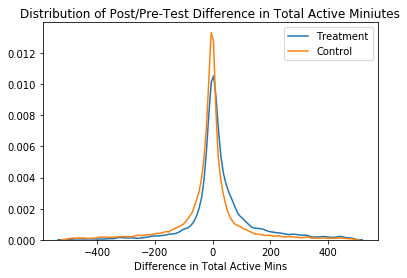

In [652]:
build_dist(t123[(t123.variant_number==1) & 
                (t123.active_mins_diff < t123.active_mins_diff.quantile(0.95)) &
                (t123.active_mins_diff > t123.active_mins_diff.quantile(0.05))], 
           t123[(t123.variant_number==0) & 
                (t123.active_mins_diff < t123.active_mins_diff.quantile(0.95)) & 
                (t123.active_mins_diff > t123.active_mins_diff.quantile(0.05))],
           "active_mins_diff","active_mins_diff","Difference in Total Active Mins", "Treatment","Control",
           title='Distribution of Post/Pre-Test Difference in Total Active Miniutes')

# Add Table 4

In [654]:
t4_user_attributes.head()

,uid,gender,user_type
0,0,male,non_reader
1,1,male,reader
2,2,male,non_reader
3,3,male,non_reader
4,4,male,non_reader


In [655]:
t1234 = pd.merge(t4_user_attributes, t123, on='uid')

In [656]:
t1234.head()

,uid,gender,user_type,variant_number,dt,signup_date,active_mins_post,active_mins_pre,active_mins_diff
0,0,male,non_reader,0,2019-02-06,2018-09-24,43.0,70.0,-27.0
1,1,male,reader,0,2019-02-06,2016-11-07,15205.0,19158.0,-3953.0
2,2,male,non_reader,0,2019-02-06,2018-09-17,17.0,37.0,-20.0
3,3,male,non_reader,0,2019-02-06,2018-03-04,77.0,108.0,-31.0
4,4,male,non_reader,0,2019-02-06,2017-03-09,39.0,66.0,-27.0


In [657]:
pd.crosstab(t1234['variant_number'],t1234['gender']).apply(lambda r: r/r.sum(), axis=1)

gender,female,male,unknown
variant_number,,,
0,0.286737,0.561493,0.151770
1,0.282815,0.559083,0.158101


In [658]:
pd.crosstab(t1234['variant_number'],t1234['user_type']).apply(lambda r: r/r.sum(), axis=1)

user_type,contributor,new_user,non_reader,reader
variant_number,,,,
0,0.024415,0.061185,0.735240,0.17916
1,0.013857,0.084015,0.764648,0.13748


In [659]:
pd.crosstab(t1234['gender'],t1234['user_type']).apply(lambda r: r/r.sum(), axis=1)

user_type,contributor,new_user,non_reader,reader
gender,,,,
female,0.018734,0.074637,0.745166,0.161463
male,0.025849,0.055801,0.732579,0.185772
unknown,0.016170,0.085208,0.764342,0.134280


# Gender

In [660]:
stats1234_gender = t1234.groupby(['variant_number','gender'])['active_mins_post', 'active_mins_pre', 'active_mins_diff'].agg(['mean', 'count', 'var'])
stats1234_gender

active_mins_post                      active_mins_pre  \
                                   mean  count           var            mean   
variant_number gender                                                          
0              female        347.295635  10699  1.775838e+06      388.001309   
               male          555.593957  20951  3.547350e+06      602.397213   
               unknown       316.268939   5663  1.506830e+06      377.835246   
1              female        355.527778   2592  1.705491e+06      224.615741   
               male          534.548009   5124  3.581443e+06      341.800546   
               unknown       386.204969   1449  2.184961e+06      260.536922   

                                            active_mins_diff         \
                        count           var             mean  count   
variant_number gender                                                 
0              female   10699  2.291656e+06       -40.705673  10699   
               male     20951  4.430440e+06       -46.803255  20951   
               unknown   5663  2.361617e+06       -61.566308   5663   
1              female    2592  6.196977e+05       130.912037   2592   
               male      5124  1.663136e+06       192.747463   5124   
               unknown   1449  9.123354e+05       125.668047   1449   

                                      
                                 var  
variant_number gender                 
0              female   6.638987e+05  
               male     1.085087e+06  
               unknown  9.087380e+05  
1              female   7.495040e+05  
               male     1.270380e+06  
               unknown  7.472261e+05

In [714]:
def ConfidenceInterval(stats, attribute):
    mean_did = stats.loc[1, attribute]['active_mins_diff', 'mean'] - stats.loc[0,attribute]['active_mins_diff', 'mean']
    SE_did = np.sqrt(stats.loc[1, attribute]['active_mins_diff','var'] / stats.loc[1, attribute]['active_mins_diff','count'] + 
                     stats.loc[0, attribute]['active_mins_diff','var'] / stats.loc[0, attribute]['active_mins_diff','count'])

    upper = mean_did + (1.96 * SE_did)
    lower = mean_did - (1.96 * SE_did)
    return [lower, upper]

In [715]:
intervals = {}
for g in set(t4_user_attributes['gender']):
    intervals[g] = ConfidenceInterval(stats1234_gender, g)
    print(g, ':', ConfidenceInterval(stats1234_gender, g))

unknown : [136.26857431526759, 238.20013476417938]
female : [134.88598802514008, 208.34943290378027]
male : [205.61842607578922, 273.4830101924954]


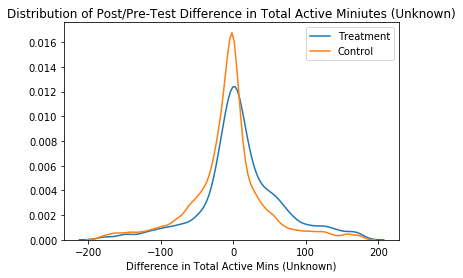

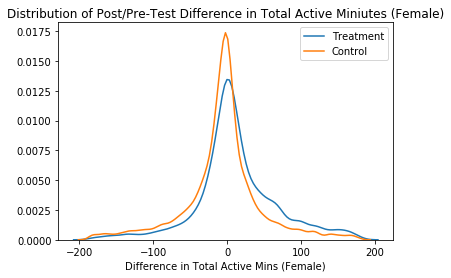

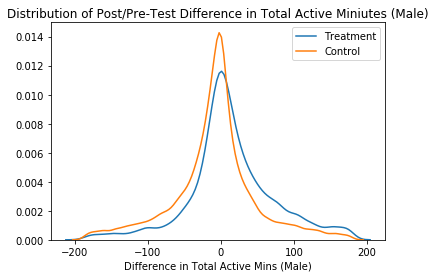

In [767]:
for g in set(t4_user_attributes['gender']):
    build_dist(t1234[(t1234.variant_number==1) & (t1234.gender==g) &
                (t1234.active_mins_diff < t1234.active_mins_diff.quantile(0.90)) &
                (t1234.active_mins_diff > t1234.active_mins_diff.quantile(0.10))], 
           t1234[(t1234.variant_number==0) & (t1234.gender==g) &
                (t1234.active_mins_diff < t1234.active_mins_diff.quantile(0.9)) & 
                (t1234.active_mins_diff > t1234.active_mins_diff.quantile(0.1))],
           "active_mins_diff","active_mins_diff","Difference in Total Active Mins " + '(' + g.title() + ')', "Treatment","Control",
           title='Distribution of Post/Pre-Test Difference in Total Active Miniutes ' + '(' + g.title() + ')')

# User Type

In [664]:
stats1234_user_type = t1234.groupby(['variant_number','user_type'])['active_mins_post', 'active_mins_pre', 'active_mins_diff'].agg(['mean', 'count', 'var'])
stats1234_user_type

active_mins_post                       \
                                       mean  count           var   
variant_number user_type                                           
0              contributor      4309.835346    911  3.489298e+07   
               new_user           29.132720   2283  2.346789e+04   
               non_reader        104.923671  27434  1.121262e+05   
               reader           1537.135378   6685  6.323741e+06   
1              contributor      4708.031496    127  5.280503e+07   
               new_user           54.623377    770  4.513559e+04   
               non_reader        164.454623   7008  1.961370e+05   
               reader           1926.734127   1260  9.683510e+06   

                           active_mins_pre                       \
                                      mean  count           var   
variant_number user_type                                          
0              contributor     4967.092206    911  4.838156e+07   
               new_user           6.105563   2283  8.846519e+01   
               non_reader       108.010352  27434  9.982839e+04   
               reader          1706.748691   6685  7.733619e+06   
1              contributor     3231.299213    127  2.824765e+07   
               new_user           6.487013    770  7.679892e+01   
               non_reader        99.442066   7008  3.998564e+04   
               reader          1268.926984   1260  3.980188e+06   

                           active_mins_diff                       
                                       mean  count           var  
variant_number user_type                                          
0              contributor      -657.256861    911  1.641526e+07  
               new_user           23.027157   2283  2.250226e+04  
               non_reader         -3.086681  27434  6.995154e+04  
               reader           -169.613313   6685  2.628631e+06  
1              contributor      1476.732283    127  2.157951e+07  
               new_user           48.136364    770  4.463679e+04  
               non_reader         65.012557   7008  1.624529e+05  
               reader            657.807143   1260  4.006790e+06

In [716]:
for g in set(t4_user_attributes['user_type']):
    intervals[g] = ConfidenceInterval(stats1234_user_type, g)
    print(g, ':', ConfidenceInterval(stats1234_user_type, g))

contributor : [1284.297301979685, 2983.680986134959]
non_reader : [58.15701884268577, 78.04145683476409]
reader : [710.25891739744, 944.5819950932107]
new_user : [8.967288343457433, 41.2511244308029]


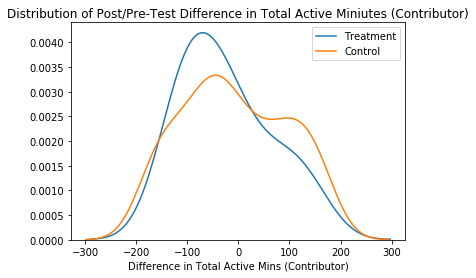

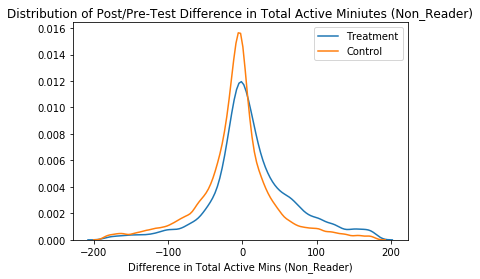

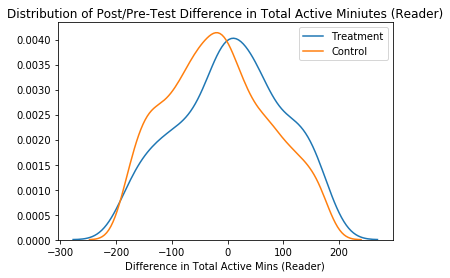

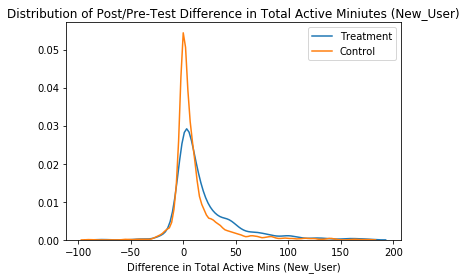

In [666]:
for g in set(t4_user_attributes['user_type']):
    build_dist(t1234[(t1234.variant_number==1) & (t1234.user_type==g) &
                (t1234.active_mins_diff < t1234.active_mins_diff.quantile(0.9)) &
                (t1234.active_mins_diff > t1234.active_mins_diff.quantile(0.10))], 
           t1234[(t1234.variant_number==0) & (t1234.user_type==g) &
                (t1234.active_mins_diff < t1234.active_mins_diff.quantile(0.9)) & 
                (t1234.active_mins_diff > t1234.active_mins_diff.quantile(0.1))],
           "active_mins_diff","active_mins_diff","Difference in Total Active Mins " + '(' + g.title() + ')', "Treatment","Control",
           title='Distribution of Post/Pre-Test Difference in Total Active Miniutes ' + '(' + g.title() + ')')

# Gender and User Type

In [706]:
stats1234 = t1234.groupby(['variant_number','user_type','gender'])['active_mins_post', 'active_mins_pre', 'active_mins_diff'].agg(['mean', 'count', 'var'])
stats1234

active_mins_post                       \
                                               mean  count           var   
variant_number user_type   gender                                          
0              contributor female       2891.901345    223  1.919445e+07   
                           male         4959.790541    592  4.056130e+07   
                           unknown      3595.520833     96  2.918201e+07   
               new_user    female         28.274590    732  2.253973e+04   
                           male           30.543119   1090  2.800025e+04   
                           unknown        27.160521    461  1.430522e+04   
               non_reader  female         91.746596   7932  1.876154e+05   
                           male          115.496277  15175  9.035496e+04   
                           unknown        92.000462   4327  4.926881e+04   
               reader      female       1281.672737   1812  5.308603e+06   
                           male         1689.815584   4094  7.074096e+06   
                           unknown      1328.952503    779  4.437375e+06   
1              contributor female       3514.038462     26  2.606714e+07   
                           male         5354.695122     82  6.312565e+07   
                           unknown      3551.052632     19  4.398827e+07   
               new_user    female         50.650000    260  1.585127e+04   
                           male           58.923288    365  6.926217e+04   
                           unknown        50.924138    145  3.735781e+04   
               non_reader  female        137.462475   1972  1.131500e+05   
                           male          184.613955   3927  2.676727e+05   
                           unknown       141.066727   1109  8.735659e+04   
               reader      female       1634.485030    334  7.857262e+06   
                           male         2071.270667    750  1.057237e+07   
                           unknown      1865.420455    176  9.208636e+06   

                                   active_mins_pre                       \
                                              mean  count           var   
variant_number user_type   gender                                         
0              contributor female      3680.219731    223  2.738305e+07   
                           male        5466.097973    592  5.576348e+07   
                           unknown     4879.187500     96  4.710011e+07   
               new_user    female         5.845628    732  5.358352e+01   
                           male           6.227523   1090  8.696931e+01   
                           unknown        6.229935    461  1.476644e+02   
               non_reader  female        97.312532   7932  2.044803e+05   
                           male         116.640461  15175  5.780595e+04   
                           unknown       97.354749   4327  5.482720e+04   
               reader      female      1409.699227   1812  6.476895e+06   
                           male        1858.350513   4094  8.442243e+06   
                           unknown     1600.966624    779  6.613186e+06   
1              contributor female      2304.115385     26  5.319186e+06   
                           male        3830.280488     82  3.965612e+07   
                           unknown     1915.000000     19  7.188150e+06   
               new_user    female         6.334615    260  6.650150e+01   
                           male           6.487671    365  8.071207e+01   
                           unknown        6.758621    145  8.637883e+01   
               non_reader  female        80.724645   1972  2.410411e+04   
                           male         108.973262   3927  4.003920e+04   
                           unknown       98.974752   1109  6.717365e+04   
               reader      female      1082.218563    334  3.044533e+06   
                           male        1342.662667    750  4.202627e+06   
                           unkno

In [711]:
covariates = [[a,b] for a in set(t4_user_attributes['user_type']) for b in set(t4_user_attributes['gender'])]
len(covariates)

12

In [712]:
def ConfidenceInterval_covariate(stats, covariate):
    mean_did = stats.loc[1, covariate[0], covariate[1]]['active_mins_diff', 'mean'] - stats.loc[0, covariate[0], covariate[1]]['active_mins_diff', 'mean']
    SE_did = np.sqrt(stats.loc[1, covariate[0], covariate[1]]['active_mins_diff','var'] / stats.loc[1, covariate[0], covariate[1]]['active_mins_diff','count'] + 
                     stats.loc[0, covariate[0], covariate[1]]['active_mins_diff','var'] / stats.loc[0, covariate[0], covariate[1]]['active_mins_diff','count'])

    upper = mean_did + (1.96 * SE_did)
    lower = mean_did - (1.96 * SE_did)
    return [lower, upper]

In [717]:
for c in covariates:
    intervals['_'.join(c)] = ConfidenceInterval_covariate(stats1234, c)
    print(c, ':', ConfidenceInterval_covariate(stats1234, c))

['contributor', 'unknown'] : [653.6048080357796, 5185.8337884554485]
['contributor', 'female'] : [343.4674981069095, 3653.0154270396924]
['contributor', 'male'] : [925.4251510097495, 3136.018982147799]
['non_reader', 'unknown'] : [28.39717566566377, 66.49534790818825]
['non_reader', 'female'] : [49.22753265482336, 75.3799974770583]
['non_reader', 'male'] : [61.20339354405016, 92.36636076534171]
['reader', 'unknown'] : [545.8458322158888, 1110.9551363918833]
['reader', 'female'] : [460.6913673558314, 899.8945469083554]
['reader', 'male'] : [739.678278996958, 1054.607579332304]
['new_user', 'unknown'] : [-9.935825860614052, 56.405688976778315]
['new_user', 'female'] : [3.262515103845068, 40.5103306296564]
['new_user', 'male'] : [-0.4068322301028964, 56.646872446264766]


In [718]:
df_intervals = pd.DataFrame(intervals)

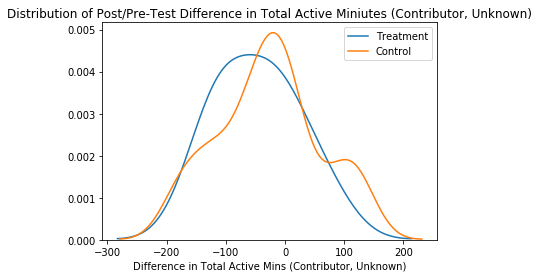

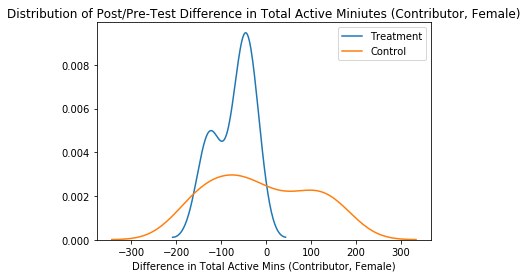

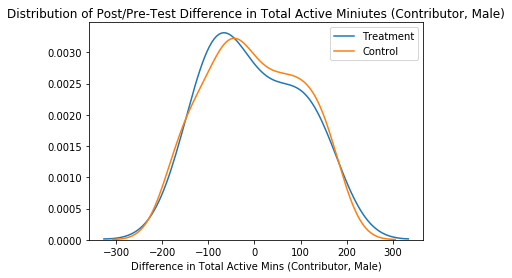

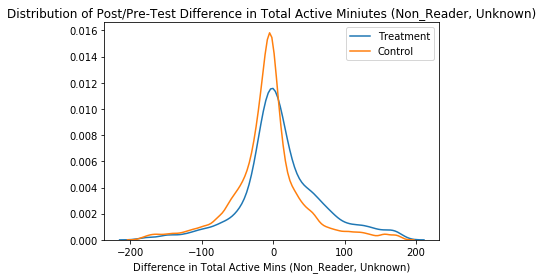

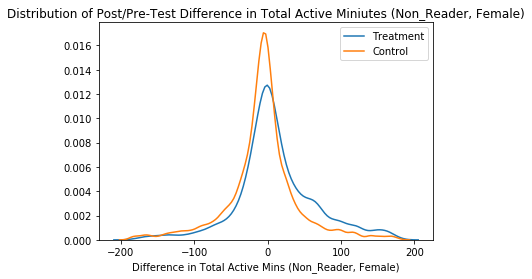

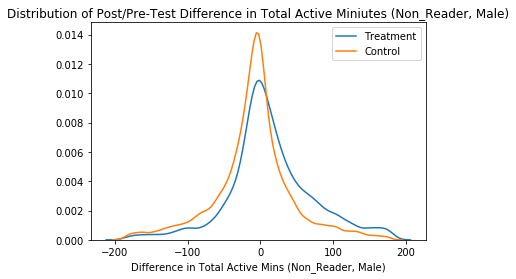

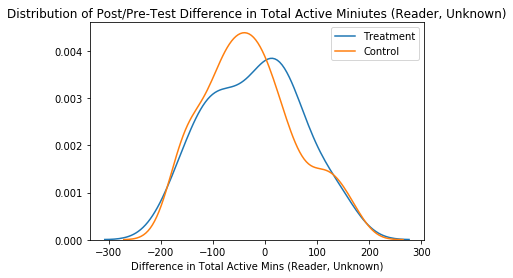

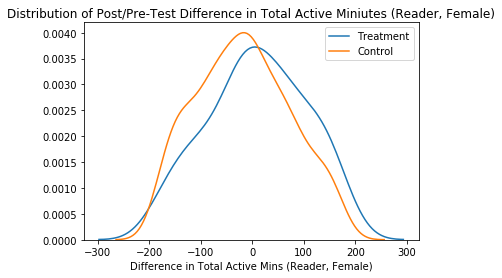

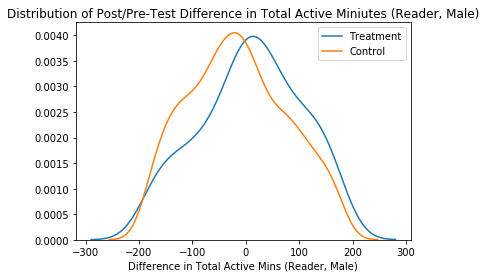

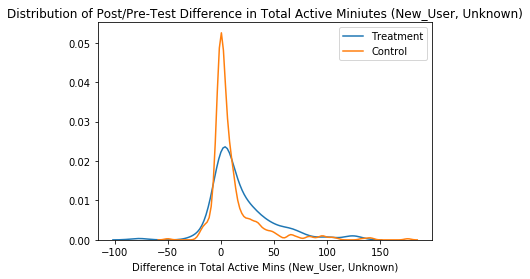

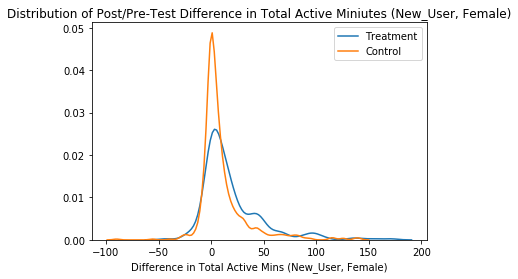

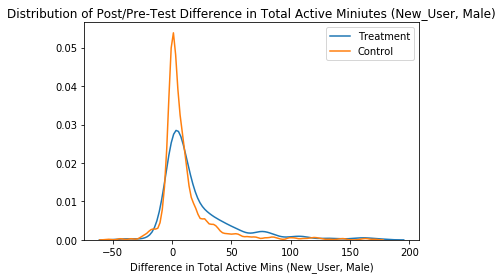

In [769]:
for c in covariates:
    build_dist(t1234[(t1234.variant_number==1) & (t1234.user_type==c[0]) & (t1234.gender==c[1]) &
                (t1234.active_mins_diff < t1234.active_mins_diff.quantile(0.90)) &
                (t1234.active_mins_diff > t1234.active_mins_diff.quantile(0.10))], 
           t1234[(t1234.variant_number==0) & (t1234.user_type==c[0]) & (t1234.gender==c[1]) &
                (t1234.active_mins_diff < t1234.active_mins_diff.quantile(0.90)) & 
                (t1234.active_mins_diff > t1234.active_mins_diff.quantile(0.1))],
           "active_mins_diff","active_mins_diff","Difference in Total Active Mins " + '(' + c[0].title() + ', ' + c[1].title() + ')', "Treatment","Control",
           title='Distribution of Post/Pre-Test Difference in Total Active Miniutes ' + '(' + c[0].title() + ', ' + c[1].title() + ')')

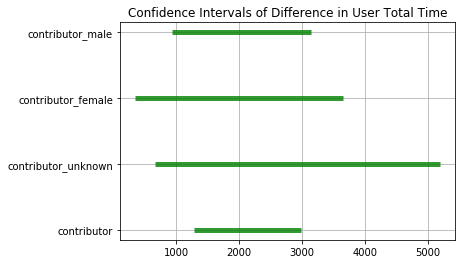

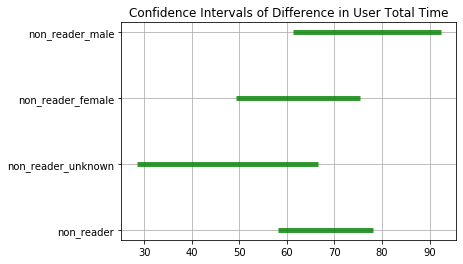

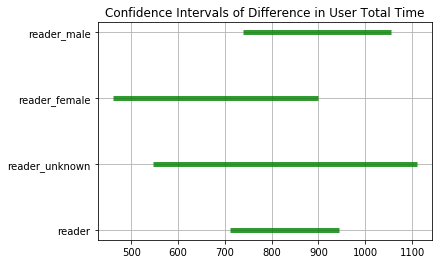

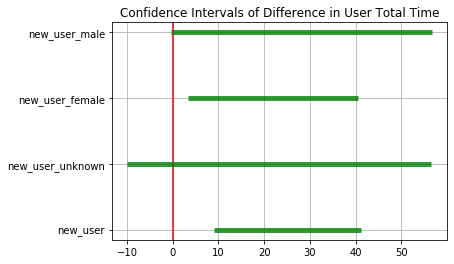

In [771]:
for u in set(t4_user_attributes.user_type):
    plt.figure()
    plt.title('Confidence Intervals of Difference in User Total Time')
    plt.grid()
    plt.vlines(0, -1, 4, colors='r')
    for i in df_intervals.columns[df_intervals.columns.str.startswith(u)]:
        plt.hlines(i, df_intervals[i][0], df_intervals[i][1], colors='g', alpha=0.8, linestyles='solid', label=i, linewidth=5.0)